In [1]:
#Functions

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd
import numpy as np
import cv2

# Lossless Encoder using Run-Length Encoding (RLE)


from heapq import heappush, heappop, heapify
from collections import defaultdict

class HuffmanEncoder:
    def __init__(self):
        self.codes = {}
        self.reverse_mapping = {}
    
    def frequency_table(self, data):
        freq = defaultdict(int)
        for value in data:
            freq[value] += 1
        return freq
    
    def build_heap(self, freq):
        heap = [[weight, [value, ""]] for value, weight in freq.items()]
        heapify(heap)
        return heap
    
    def build_tree(self, heap):
        while len(heap) > 1:
            low = heappop(heap)
            high = heappop(heap)
            for pair in low[1:]:
                pair[1] = "0" + pair[1]
            for pair in high[1:]:
                pair[1] = "1" + pair[1]
            heappush(heap, [low[0] + high[0]] + low[1:] + high[1:])
        return heappop(heap)
    
    def create_codes(self, heap):
        for pair in heap[1:]:
            self.codes[pair[0]] = pair[1]
            self.reverse_mapping[pair[1]] = pair[0]
    
    def encode(self, image):
        flat_image = image.flatten()
        freq = self.frequency_table(flat_image)
        heap = self.build_heap(freq)
        tree = self.build_tree(heap)
        self.create_codes(tree)
        
        # Create encoded bitstream
        bitstream = "".join(self.codes[value] for value in flat_image)
        
        # Group into 8-bit chunks
        grouped_bitstream = [bitstream[i:i+8] for i in range(0, len(bitstream), 8)]
        return grouped_bitstream, self.codes
    
class HuffmanDecoder:
    def __init__(self, codes):
        self.reverse_mapping = {v: k for k, v in codes.items()}
    
    def decode(self, bitstream, shape):
        binary_string = "".join(bitstream)
        current_code = ""
        decoded_pixels = []
        
        for bit in binary_string:
            current_code += bit
            if current_code in self.reverse_mapping:
                decoded_pixels.append(self.reverse_mapping[current_code])
                current_code = ""
        
        # Ensure decoded pixels match the expected size
        expected_size = shape[0] * shape[1]
        if len(decoded_pixels) > expected_size:
            decoded_pixels = decoded_pixels[:expected_size]  # Truncate excess pixels
        elif len(decoded_pixels) < expected_size:
            decoded_pixels.extend([0] * (expected_size - len(decoded_pixels)))  # Pad with zeros

        return np.array(decoded_pixels, dtype=np.uint8).reshape(shape)




# Metric Calculations
def calculate_metrics(original_image1, reconstructed_image1, bitstream1,
                      original_image2, reconstructed_image2, bitstream2):
    # Calculate MSE for both images
    mse1 = np.mean((original_image1 - reconstructed_image1) ** 2)
    mse2 = np.mean((original_image2 - reconstructed_image2) ** 2)
    SUM = mse1 + mse2
    
    # Calculate compression ratio (ρ)
    total_bits_original = 2 * 1200 * 1200 * 8
    total_bits_compressed = sum(len(chunk) for chunk in bitstream1) + sum(len(chunk) for chunk in bitstream2)
    rho = total_bits_compressed / total_bits_original
    
    # Combined score
    score = SUM + (200 * rho)
    
    print(f"Compressed Bits (Image1): {sum(len(chunk) for chunk in bitstream1)}")
    print(f"Compressed Bits (Image2): {sum(len(chunk) for chunk in bitstream2)}")
    print(f"Original Bits: {total_bits_original}")
    print(f"Compression Ratio (ρ): {rho}")
    return SUM, rho, score

def process_images(image1_path, image2_path):
    # Load the images
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Encode
    encoder = HuffmanEncoder()
    bitstream1, codes1 = encoder.encode(image1)
    bitstream2, codes2 = encoder.encode(image2)
    
    # Check bitstream sizes
    print(f"Bitstream1 size: {sum(len(chunk) for chunk in bitstream1)} bits")
    print(f"Bitstream2 size: {sum(len(chunk) for chunk in bitstream2)} bits")
    
    # Decode
    decoder1 = HuffmanDecoder(codes1)
    decoder2 = HuffmanDecoder(codes2)
    
    # Decode images and print sizes
    reconstructed_image1 = decoder1.decode(bitstream1, image1.shape)
    reconstructed_image2 = decoder2.decode(bitstream2, image2.shape)
    
    print(f"Reconstructed Image 1 shape: {reconstructed_image1.shape}")
    print(f"Reconstructed Image 2 shape: {reconstructed_image2.shape}")
    
    # Calculate metrics
    SUM, rho, score = calculate_metrics(image1, reconstructed_image1, bitstream1, image2, reconstructed_image2, bitstream2)
    print(f"MSE (SUM): {SUM}")
    print(f"Compression Ratio (ρ): {rho}")
    print(f"Combined Score: {score}")
    
    # Create submission
    max_len = max(len(bitstream1), len(bitstream2), image1.size)
 
    flat_image1 = reconstructed_image1.flatten().tolist() 
    flat_image2 = reconstructed_image2.flatten().tolist() 
    size1,size2=len(flat_image1)-len(bitstream1),len(flat_image2)-len(bitstream2)
    submission = pd.DataFrame({
    "ID": list(range(1200*1200)),
    "CompressedImage1": np.array(bitstream1+(["I"]*size1)),
    "CompressedImage2":  np.array(bitstream2+(["I"]*size2)),
    "Image1": np.array(reconstructed_image1).flatten(),
    "Image2": np.array(reconstructed_image2).flatten()} )

    
    return submission,reconstructed_image1,reconstructed_image2


In [ ]:
# Paths to the images (replace with your file paths)
image1_path = "Watermarked_Image1.tiff"
image2_path = "Watermarked_Image2.tiff"

# Process the images and create the submission DataFrame
submission ,r1,r2= process_images(image1_path, image2_path)

# Save the submission DataFrame as CSV
submission.to_csv("submission.csv", index=False)

# Display a portion of the submission
print(submission.head())

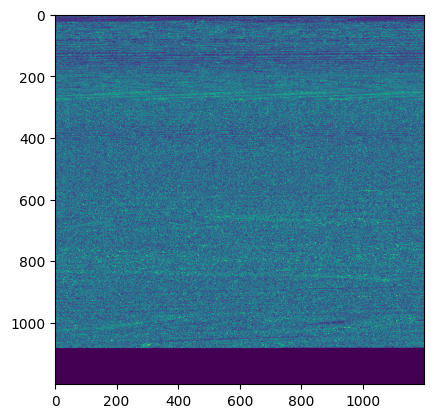

In [ ]:
plt.imshow(r1)
# plt.imshow(r2)
plt.show()
